In [1]:
# initialize stuff
import sys
import logging
import importlib

import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit

# import theory stuff

HOME_DIR = "/Users/oliver/Documents/p5control-bluefors-evaluation"
sys.path.append(HOME_DIR)

import superconductivity.api as sc

from superconductivity.style.cpd4 import cmap, colors

import numpy as np

from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D

import superconductivity.api as sc

from superconductivity.api import G_0_muS
from superconductivity.api import NDArray64

from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("matplotlib", "inline")
    _ip.run_line_magic("reload_ext", "autoreload")
    _ip.run_line_magic("autoreload", "2")

    _ip.run_line_magic(
        "config",
        "InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}",
    )
    _ip.run_line_magic("config", 'InlineBackend.figure_format = "retina"')  # or "png"
    _ip.run_line_magic(
        "config", "InlineBackend.rc = {'figure.dpi': 300}"
    )  # choose a value you like

(base) ... BaseClass initialized.
(base eva) ... BaseEvaluation initialized.
(iv eva) ... IVEvaluation initialized.
(base) ... BaseClass initialized.
(base plot) ... BasePlot initialized.
(iv plot) ... IVPlot initialized.
(base) Amplitude Study (15GHz, Antenna)
(base) loadData()
(base plot) saveFigure()
(base plot) saveFigure()


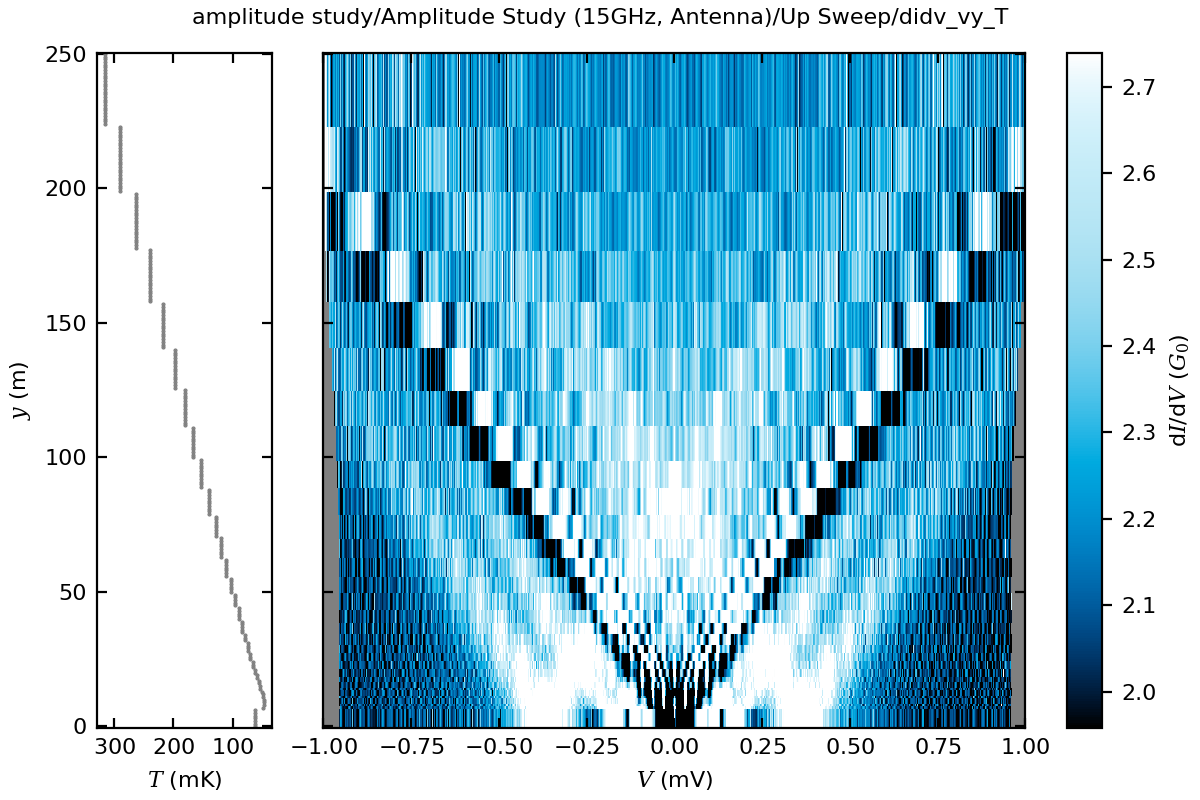

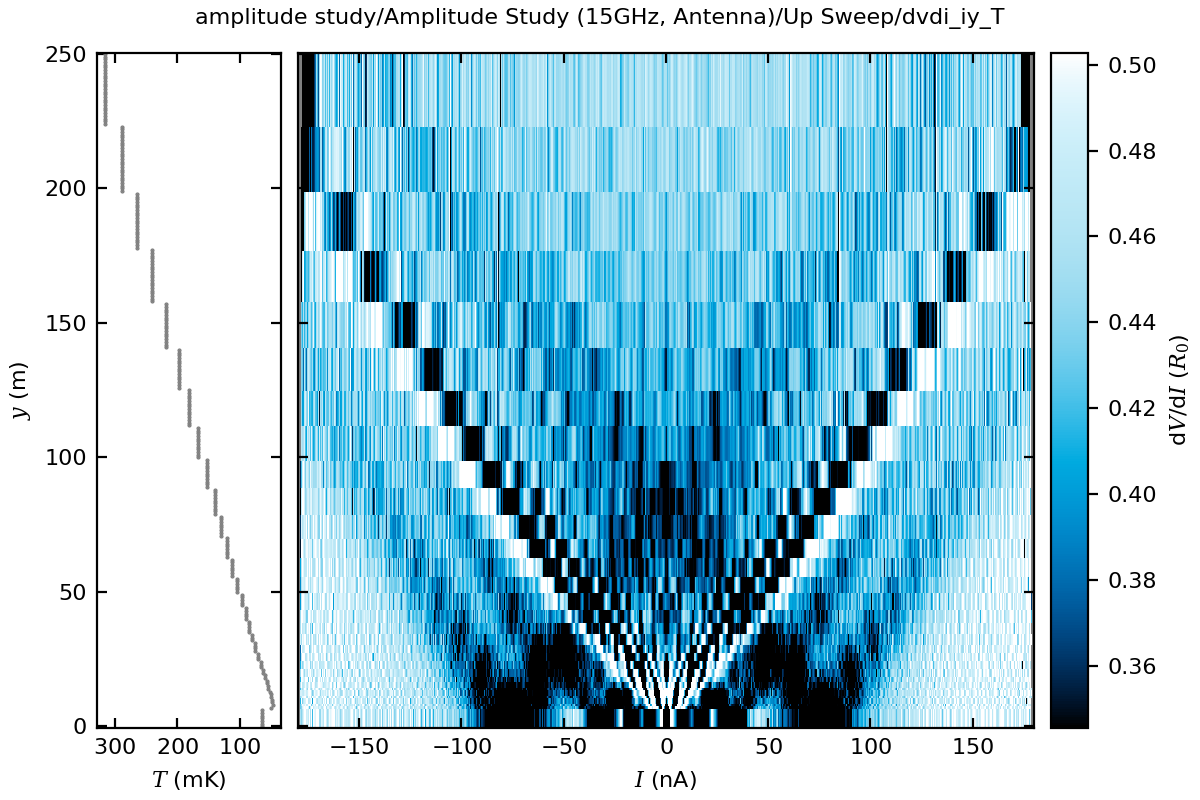

In [2]:
from utilities.ivplot import IVPlot

importlib.reload(sys.modules["utilities.ivevaluation"])
eva = IVPlot()
eva.sub_folder = ""
eva.title = "Amplitude Study (15GHz, Antenna)"
eva.loadData()
eva.to_plot = eva.up_sweep
eva.plot_all()

In [3]:
V_mV = eva.mapped["voltage_axis"] * 1e3
A_out_mV = eva.mapped["amplitude_axis"] * 1e3

I_exp_nA = eva.up_sweep["current"] * 1e9
T_exp_K = eva.up_sweep["temperature"]
dIdV_exp = eva.up_sweep["differential_conductance"]


# I_tmp_nA = np.copy(I_exp_nA)
# V_tmp_mV = np.copy(V_mV)
# V_mV = np.linspace(-1, 1, 501, dtype=np.float64)
# I_exp_nA = np.full((A_out_mV.shape[0], V_mV.shape[0]), np.nan, dtype=np.float64)
# for i, a_mV in enumerate(A_out_mV):
#     temp = I_tmp_nA[i, :]
#     mask = np.logical_not(np.isnan(temp))
#     I_exp_nA[i, :] = sc.bin_y_over_x(V_tmp_mV[mask], temp[mask], V_mV)

# dIdV_exp = np.gradient(I_exp_nA, V_mV, axis=1) / sc.G_0_muS

(T, Δ, γ):   0%|          | 0/441 [00:00<?, ?it/s]

generation_time = 7.93 s
fitting_time = 52.51 s
--------------------------
310330 possibilities within
(1.7 - 2.2) G_0, for
7 channels and
48 transmissions
--------------------------
for 441 parameter
- 9 temperatures
- 7 energy gaps
- 7 dynes parameter
 
τ_0 = -0.05 (0.07)
τ_1 = 0.03 (0.07)
τ_2 = 0.08 (0.07)
τ_3 = 0.16 (0.08)
τ_4 = 0.31 (0.13)
τ_5 = 0.66 (0.07)
τ_6 = 0.78 (0.04)
Στ = 1.97
--------------------------
T_fit = 0.1 K
Δ_fit = 188.0 μeV
γ_fit = 9.00 μeV


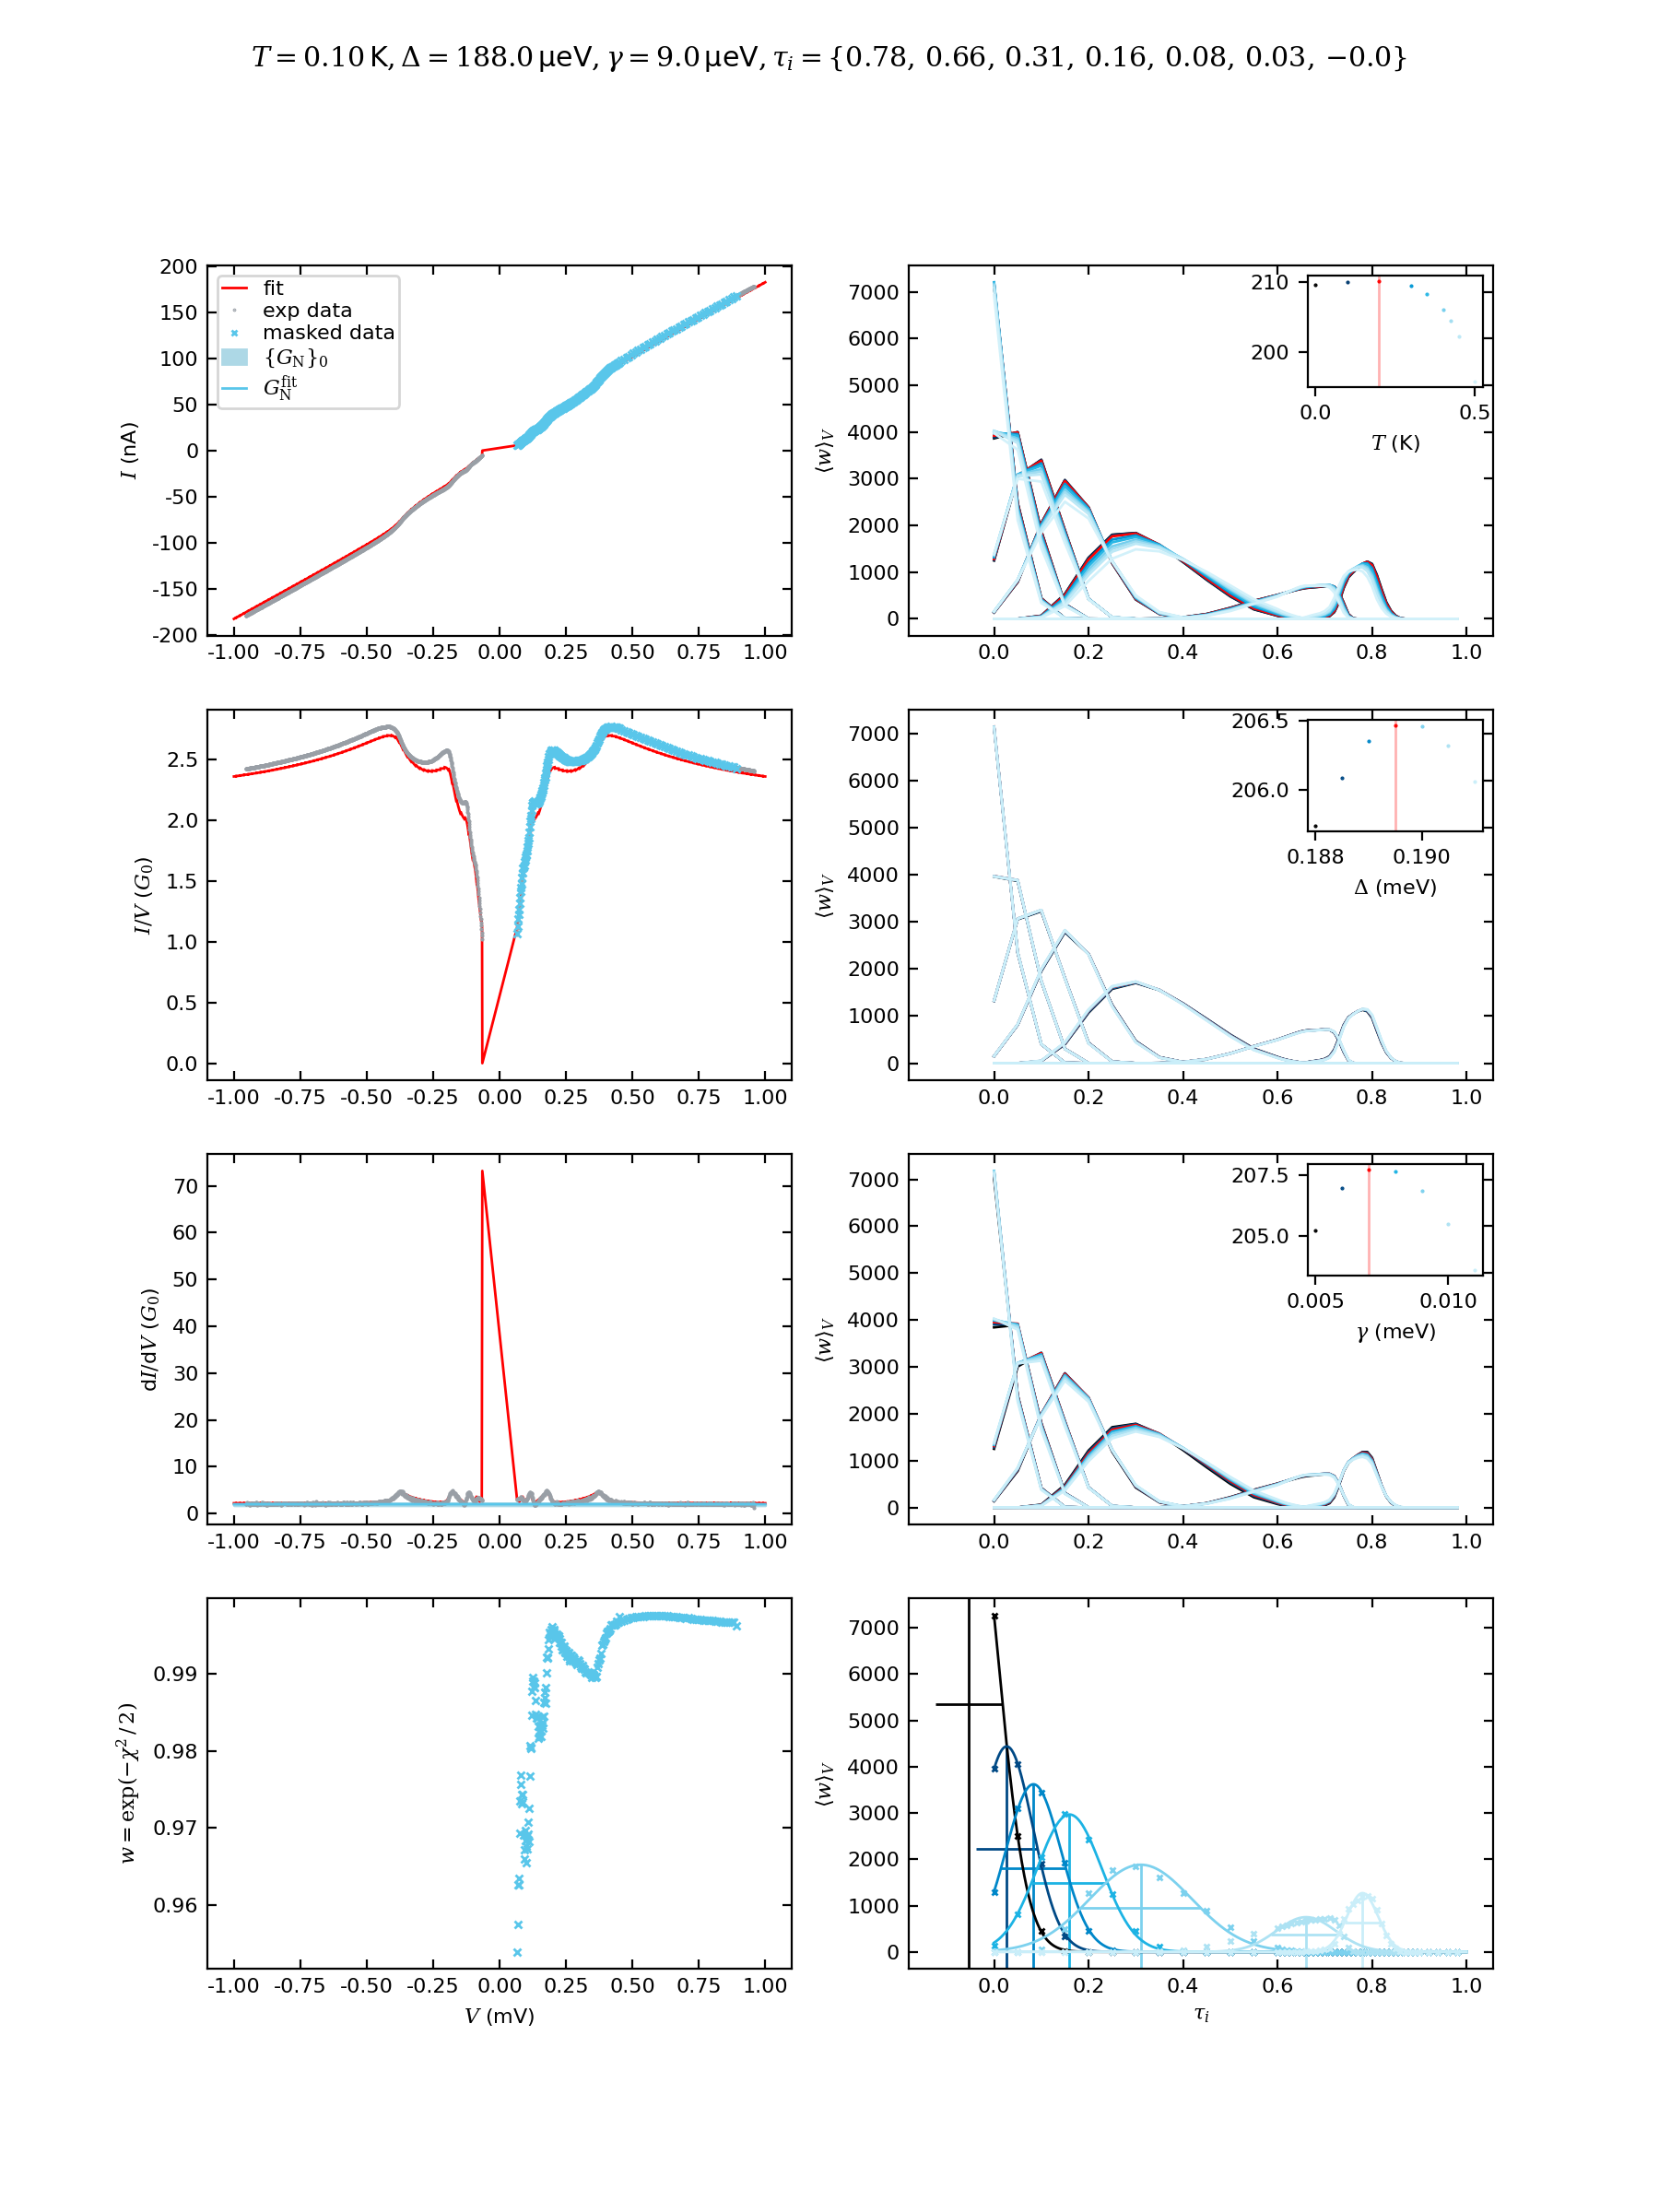

In [4]:
from superconductivity.optimizers.fit_atomic_contact import fit_atomic_contact

Delta_theo_meV = np.array(
    [
        0.182,
        0.184,
        0.186,
        0.188,
        0.1885,
        0.189,
        0.1895,
        0.190,
        0.192,
    ],
    dtype=np.float64,
)
gamma_theo_meV = np.arange(
    0,
    0.011,
    0.001,
    dtype=np.float64,
)


T_theo_K = np.array([0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.425, 0.45, 0.5], dtype=np.float64)
gamma_theo_meV = np.array(
    [5e-3, 6e-3, 7e-3, 8e-3, 9e-3, 10e-3, 11e-3],
    dtype=np.float64,
)
Delta_theo_meV = np.array(
    [0.188, 0.1885, 0.189, 0.1895, 0.190, 0.1905, 0.191],
    dtype=np.float64,
)
# gamma_theo_meV = np.array([0],
#             dtype=np.float64,
#         )

# T_theo_K = np.array([0],
#             dtype=np.float64,
#         )

mask = np.abs(V_mV) >= 0.065  # cut away supercurrent
solution = fit_atomic_contact(
    V_exp_mV=V_mV[mask],
    I_exp_nA=I_exp_nA[0, mask],
    Tau_min=1.7,
    Tau_max=2.2,
    n_channel=7,
    T_theo_K=T_theo_K,
    Delta_theo_meV=Delta_theo_meV,
    gamma_theo_meV=gamma_theo_meV,
    pbar_gen_theo=False,
)

from superconductivity.optimizers.fit_atomic_contact_plotter import plot_atomic_contact

plot_atomic_contact(solution)

In [5]:
# # history

# from superconductivity.optimizers.fit_atomic_contact_plotter import plot_atomic_contact

# if _ip is not None:
#     _ip.run_line_magic("matplotlib", "qt")
#     plot_atomic_contact(solution)
#     _ip.run_line_magic("matplotlib", "inline")

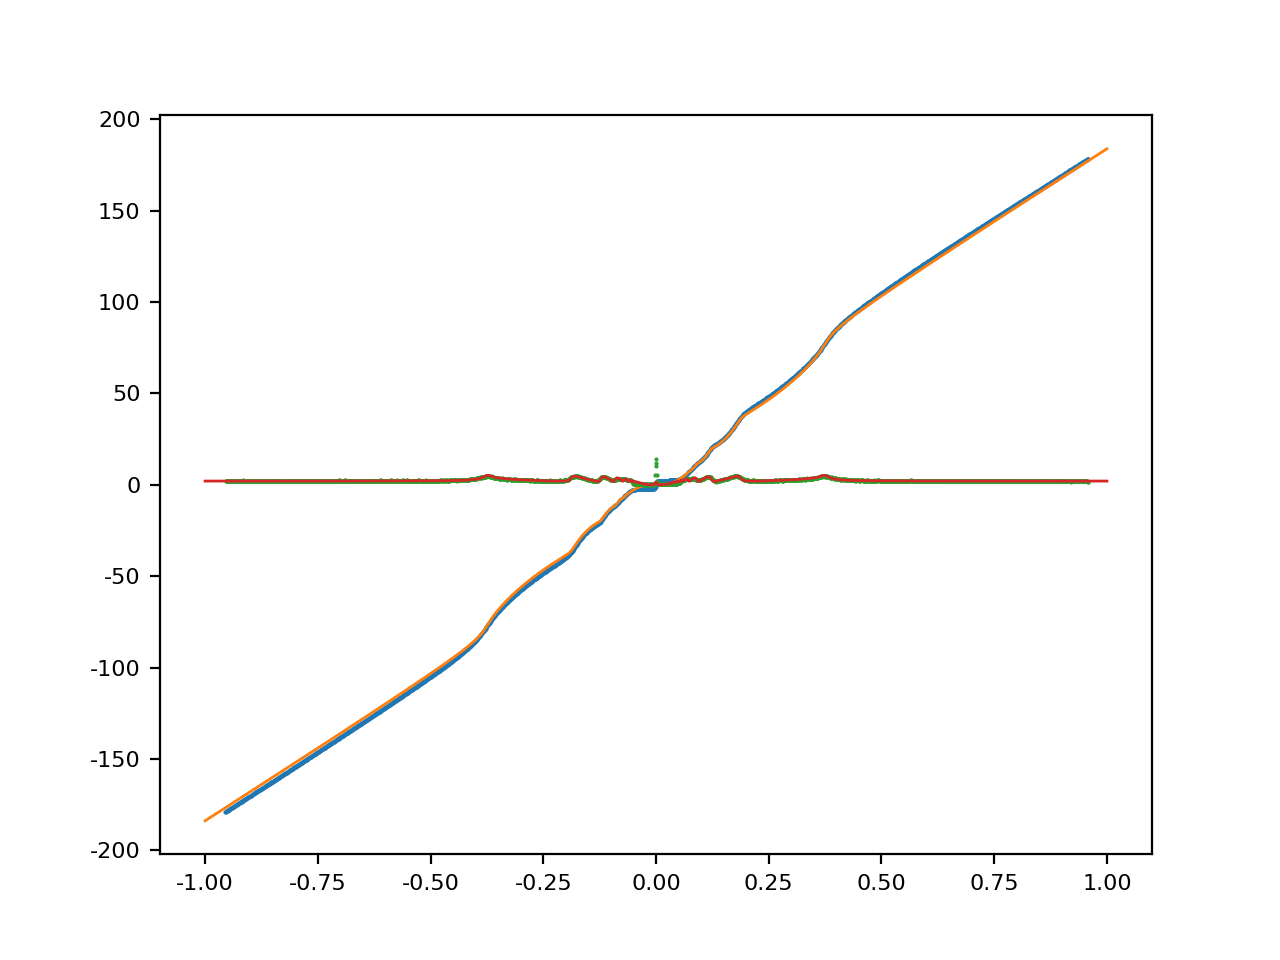

In [6]:
# nachfitten
tau = np.array([0.78, 0.66, 0.31, 0.16, 0.08, 0.03])
G_N = np.sum(tau)

T_K = 0.3
Delta_meV = 0.1885
gamma_meV = 4e-3

I_ha_nA = np.zeros((tau.shape[0], V_mV.shape[0]))
for i_tau, tau_i in enumerate(tau):
    i_ha_nA = sc.get_I_ha_nA(
        V_mV=V_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
        gamma_meV_min=1e-7,
    )
    I_ha_nA[i_tau, :] = i_ha_nA
I_ha_nA = np.sum(I_ha_nA, axis=0)
dIdV_ha = np.gradient(I_ha_nA, V_mV) / sc.G_0_muS

plt.figure(199)
plt.plot(V_mV, I_exp_nA[0, :], ".")
plt.plot(V_mV, I_ha_nA)  #

plt.plot(V_mV, dIdV_exp[0, :], ".")
plt.plot(V_mV, dIdV_ha, "-")

In [7]:
# simulation parameter
tau = np.array([0.78, 0.66, 0.31, 0.16, 0.08, 0.03])
G_N = np.sum(tau)

T_K = 0.3
Delta_meV = 0.1885
gamma_meV = 4e-3

V = V_mV / Delta_meV

nu_GHz = 15.0
A_hnu = np.linspace(0, 23, 251)
A_mV = A_hnu * sc.h_e_pVs * nu_GHz
m = np.arange(1, 11, 1)

I_exp = I_exp_nA / (sc.G_0_muS * Delta_meV)

A_interest_mV: list[float] = [0, 12.5, 25, 50]  # mV

In [8]:
# i_fcs
I_fcs_nA = np.zeros((tau.shape[0], V_mV.shape[0], 11))
I_ha_nA = np.zeros((tau.shape[0], V_mV.shape[0]))
for i_tau, tau_i in enumerate(tau):
    i_fcs_nA = sc.get_I_fcs_nA(
        V_mV=V_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=(gamma_meV, gamma_meV),
        gamma_meV_min=1e-7,
    )
    i_ha_nA = sc.get_I_ha_nA(
        V_mV=V_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
        gamma_meV_min=1e-7,
    )
    I_fcs_nA[i_tau, :, :] = i_fcs_nA[:, :]
    I_ha_nA[i_tau, :] = i_ha_nA

I_bcs_nA = sc.get_I_bcs_nA(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_fcs_nA = np.sum(I_fcs_nA, axis=0)
I_ha_nA = np.sum(I_ha_nA, axis=0)

cached values: 1001/1001
cached values: 1001/1001
cached values: 1001/1001
cached values: 1001/1001
cached values: 1001/1001
cached values: 1001/1001


In [9]:
# # i_utg
# from utg import get_I_nA as get_I_utg_nA

# I_pamar_nA = get_I_utg_nA(
#     A_mV=A_mV,
#     V_mV=V_mV,
#     I_nA=I_fcs_nA,
#     nu_GHz=nu_GHz,
#     N=100,
#     M=10,
# )
# I_pamar_nA = np.sum(I_pamar_nA[:, :, 1:], axis=2)
# I_pamar = I_pamar_nA / (sc.G_0_muS * Delta_meV)
# dIdV_pamar = np.gradient(I_pamar_nA, V_mV, axis=1) / sc.G_0_muS

In [10]:
# i_pat_m
I_pat_m_nA = np.zeros((m[:-1].shape[0], A_mV.shape[0], V_mV.shape[0]))

for i_m, m_i in enumerate(m[:-1]):
    I_fcs_m_nA = I_fcs_nA[:, i_m + 1]
    I_pat_m_nA[i_m, :, :] = sc.get_I_pat_nA(
        V_mV=V_mV,
        I_nA=I_fcs_m_nA,
        A_mV=A_mV,
        nu_GHz=nu_GHz,
        m=m_i,
        n_max=500,
    )
I_pamar_nA = np.sum(I_pat_m_nA, axis=0)

I_pat_m = I_pat_m_nA / (sc.G_0_muS * Delta_meV)
I_pamar = np.sum(I_pat_m, axis=0)

dIdV_pat_m = np.gradient(I_pat_m_nA, V_mV, axis=2) / sc.G_0_muS
dIdV_pamar = np.sum(dIdV_pat_m, axis=0)

I_pat_nA = sc.get_I_pat_nA(
    V_mV=V_mV,
    I_nA=I_bcs_nA,
    A_mV=A_mV,
    nu_GHz=nu_GHz,
    m=1,
)

I_pat = I_pat_nA / (sc.G_0_muS * Delta_meV)
dIdV_pat = np.gradient(I_pat_nA, V_mV, axis=1)

(0.0, 2.8)

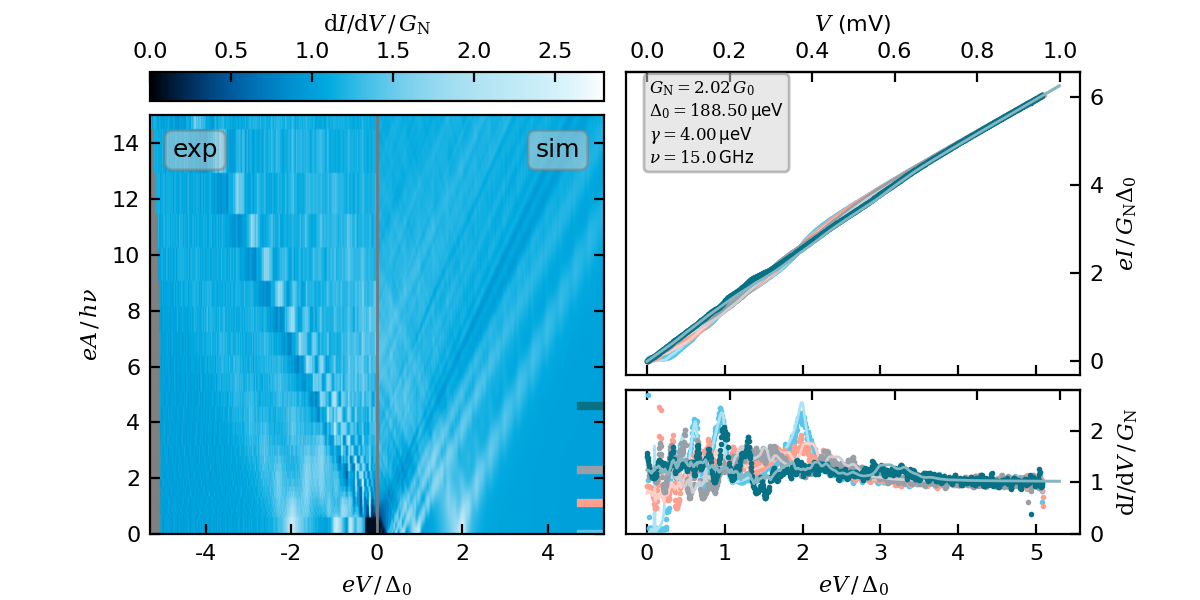

In [21]:
# exp / pamar + iv
def VtoE(V_mV):
    return V_mV / Delta_meV


def EtoV(E_meV):
    return E_meV * Delta_meV


E_label = r"$V$ (mV)"
V_label = r"$eV\,/\,\Delta_0$"
I_label = r"$eI\,/\,G_\mathrm{N}\Delta_0$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"
y_label = r"$eA\,/\,h\nu$"

index0 = np.argmin(np.abs(V_mV / Delta_meV))
index1 = np.argmin(np.abs(V_mV / Delta_meV - 8))
img_z = np.concatenate((dIdV_exp[:, 1:index0], dIdV_pamar[:, index0:]), axis=1) / G_N
img_x = V_mV / Delta_meV
img_y = A_hnu

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

A_indices = []
for A_in in A_interest_mV:
    A_indices.append(np.argmin(np.abs(A_out_mV - A_in)))

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=3,
    ncols=2,
    height_ratios=(0.2, 1.8, 1),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_clb = axs[0, 0]

gs = axs[0, 1].get_gridspec()
for ax in axs[1:, 0]:
    ax.remove()
ax_img = fig.add_subplot(gs[1:, 0])

gs = axs[1, 0].get_gridspec()
for ax in axs[:2, 1]:
    ax.remove()
ax_i = fig.add_subplot(gs[:2, 1])

ax_g = axs[2, 1]

for ax in [ax_clb, ax_img, ax_i, ax_g]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=False,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_img.imshow(
    img_z,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)
ax_img.vlines(0, ymin=ext[2], ymax=ext[3], color=sc.seegrau100)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
    orientation="horizontal",
    location="top",
)

ax_img_xlim = ax_img.get_xlim()
for i, A_i in enumerate(A_indices):
    color_exp = colors(i)
    color_fit = colors(i, 0.5)
    ax_i.plot(
        img_x[index0:index1],
        I_exp[A_i, index0:index1] / G_N,
        ".",
        ms=2,
        color=color_exp,
    )
    ax_i.plot(
        img_x[index0:index1], I_pamar[A_i, index0:index1] / G_N, "-", color=color_fit
    )
    ax_g.plot(
        img_x[index0:index1],
        dIdV_exp[A_i, index0:index1] / G_N,
        ".",
        ms=2,
        color=color_exp,
    )
    ax_g.plot(
        img_x[index0:index1], dIdV_pamar[A_i, index0:index1] / G_N, "-", color=color_fit
    )
    ax_img.plot(
        (ax_img_xlim[1] * 0.9, ax_img_xlim[1]),
        (img_y[A_i], img_y[A_i]),
        color=color_exp,
        lw=3,
    )


ax_i_2 = ax_i.secondary_xaxis("top", functions=(EtoV, VtoE))
ax_i_2.tick_params(direction="in", top=True)
ax_g_2 = ax_g.secondary_xaxis("top", functions=(EtoV, VtoE))
ax_g_2.tick_params(direction="in", top=True)

ax_i.xaxis.set_ticklabels([])
ax_g_2.xaxis.set_ticklabels([])

ax_g.yaxis.set_label_position("right")
ax_g.yaxis.tick_right()

ax_i.yaxis.set_label_position("right")
ax_i.yaxis.tick_right()

ax_img.set_ylabel(y_label)
ax_img.set_xlabel(V_label)
ax_g.set_xlabel(V_label)
ax_g.set_ylabel(G_label)
ax_i_2.set_xlabel(E_label)
ax_i.set_ylabel(I_label)

# add text box for the statistics
stats = (
    "$G_\mathrm{N}$"
    f"$={G_N}\\,G_0$\n"
    f"$\\Delta_0={Delta_meV*1e3:.2f}\\,$µeV\n"
    f"$\\gamma={gamma_meV*1e3:.2f}\\,$µeV\n"
    f"$\\nu = {nu_GHz}\\,$GHz"
)
bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)
ax_i.text(
    0.05,
    0.7,
    stats,
    fontsize=6,
    bbox=bbox,
    transform=ax_i.transAxes,
    horizontalalignment="left",
)

ax_img.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)
ax_img.text(0.85, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

ax_img.set_ylim(0, 15)
ax_g.set_ylim(0, 2.8)


# fig.savefig(
#     f"exp_sim_{nu_GHz}GHz.png",
#     dpi=600,
#     transparent=True,
#     facecolor="none",
#     edgecolor="none",
# )

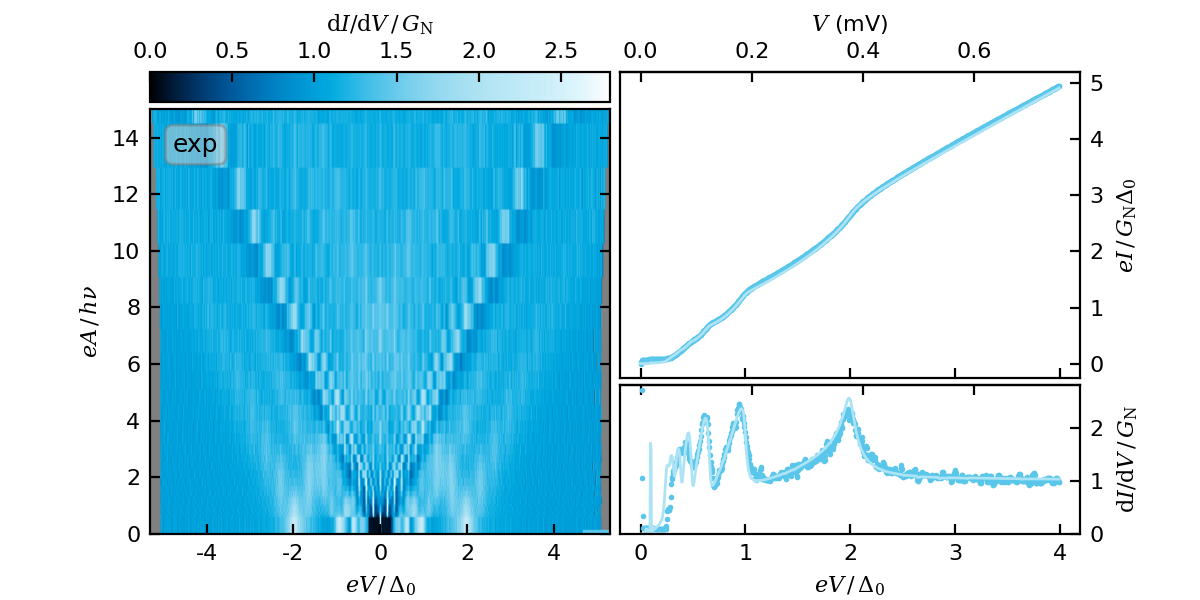

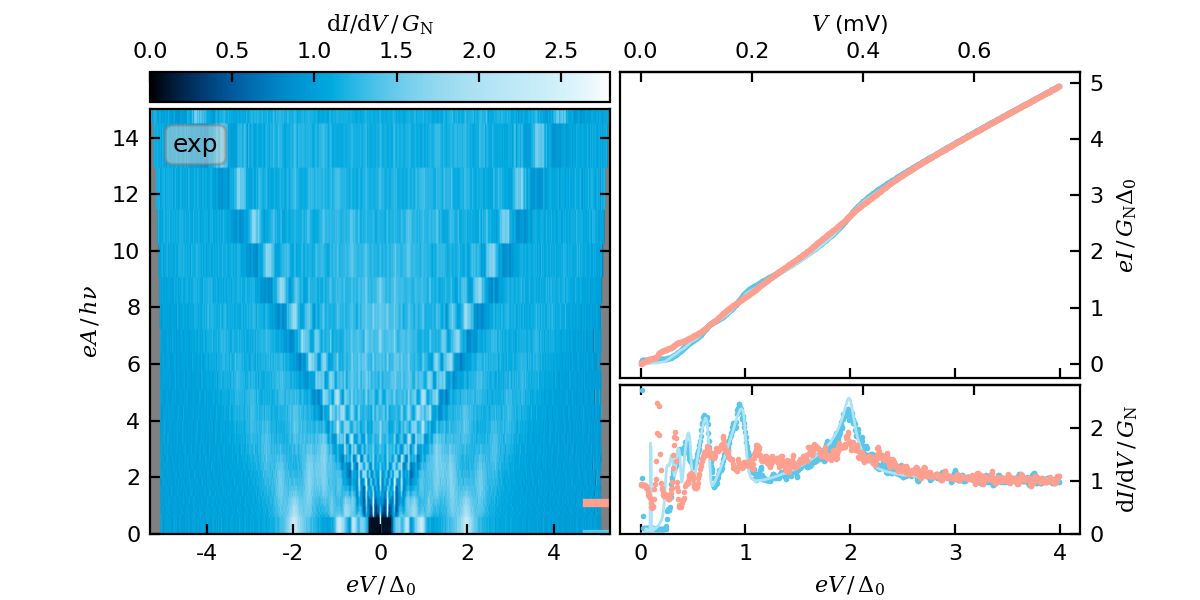

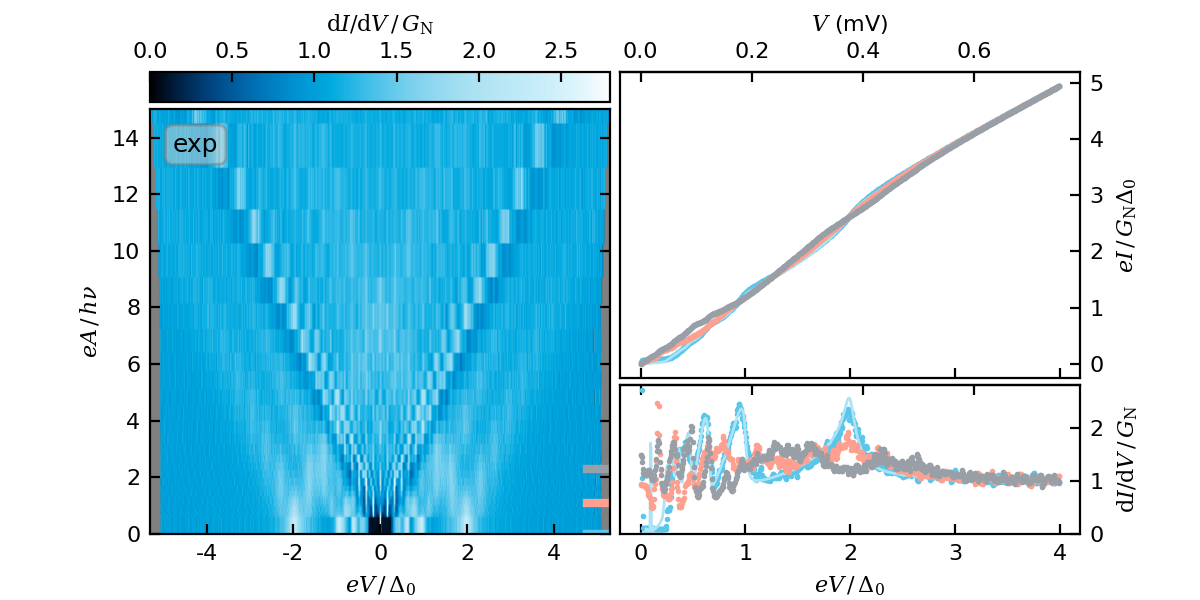

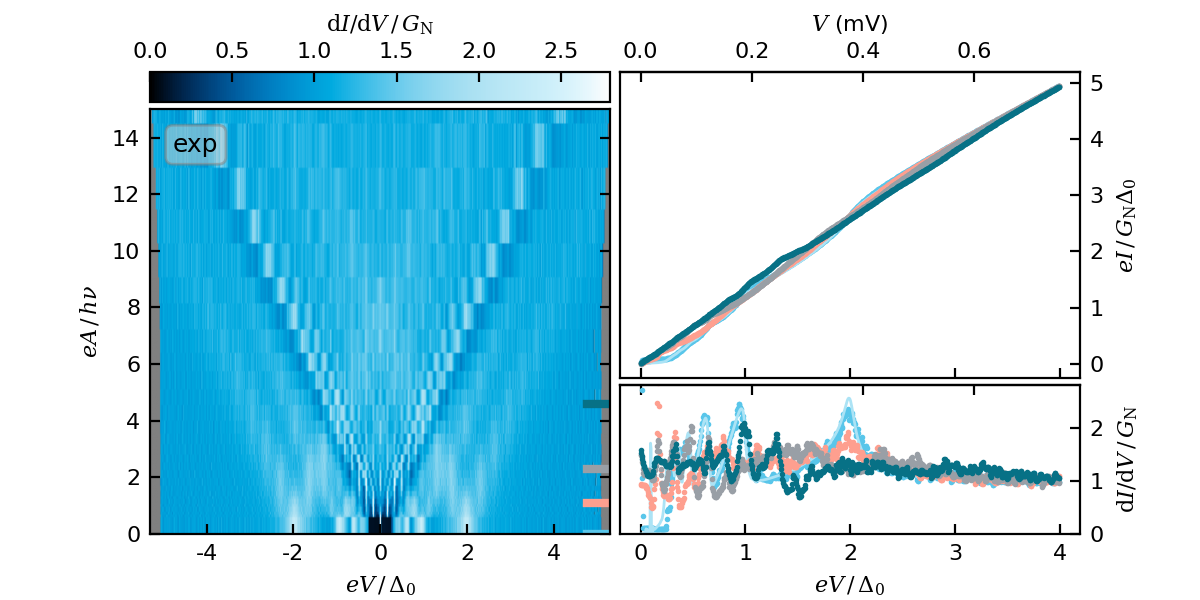

In [22]:
# exp / IV
from matplotlib.pyplot import tight_layout


def VtoE(V_mV):
    return V_mV / Delta_meV


def EtoV(E_meV):
    return E_meV * Delta_meV


E_label = r"$V$ (mV)"
V_label = r"$eV\,/\,\Delta_0$"
I_label = r"$eI\,/\,G_\mathrm{N}\Delta_0$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"
y_label = r"$eA\,/\,h\nu$"

index0 = np.argmin(np.abs(V_mV / Delta_meV))
index1 = np.argmin(np.abs(V_mV / Delta_meV - 4))
img_z = np.concatenate((dIdV_exp[:, 1:index0], dIdV_exp[:, index0:]), axis=1) / G_N
img_x = V_mV / Delta_meV
img_y = A_hnu

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

A_indices = []
for A_in in A_interest_mV:
    A_indices.append(np.argmin(np.abs(A_out_mV - A_in)))

for j, a_j in enumerate(A_interest_mV):

    # fig and axs
    fig, axs = plt.subplots(
        figsize=(6, 3),
        nrows=3,
        ncols=2,
        height_ratios=(0.1, 0.9, 0.5),
        # sharex = True
    )
    plt.subplots_adjust(hspace=0.05, wspace=0.02)
    ax_clb = axs[0, 0]

    gs = axs[0, 1].get_gridspec()
    for ax in axs[1:, 0]:
        ax.remove()
    ax_img = fig.add_subplot(gs[1:, 0])

    gs = axs[1, 0].get_gridspec()
    for ax in axs[:2, 1]:
        ax.remove()
    ax_i = fig.add_subplot(gs[:2, 1])

    ax_g = axs[2, 1]

    for ax in [ax_clb, ax_img, ax_i, ax_g]:
        ax.tick_params(
            direction="in",  # Ticks nach innen
            top=False,  # obere Ticks ein
            bottom=True,  # untere Ticks ein
            left=True,  # linke Ticks ein
            right=True,  # rechte Ticks ein
            which="both",  # sowohl Major- als auch Minor-Ticks
        )

    im = ax_img.imshow(
        img_z,
        aspect="auto",
        origin="lower",
        clim=clim,
        extent=ext,
        interpolation=None,
        cmap=cmap(bad="grey"),
    )

    cbar = fig.colorbar(
        im,
        cax=ax_clb,
        label=G_label,
        orientation="horizontal",
        location="top",
    )

    ax_img_xlim = ax_img.get_xlim()
    for i, A_i in enumerate(A_indices[: j + 1]):
        color_exp = colors(i)
        color_fit = colors(i, 0.5)
        ax_i.plot(
            img_x[index0:index1],
            I_exp[A_i, index0:index1] / G_N,
            ".",
            ms=2,
            color=color_exp,
        )
        ax_g.plot(
            img_x[index0:index1],
            dIdV_exp[A_i, index0:index1] / G_N,
            ".",
            ms=2,
            color=color_exp,
        )

        if i == 0:
            ax_i.plot(
                img_x[index0:index1],
                I_pamar[A_i, index0:index1] / G_N,
                "-",
                color=color_fit,
            )
            ax_g.plot(
                img_x[index0:index1],
                dIdV_pamar[A_i, index0:index1] / G_N,
                "-",
                color=color_fit,
            )

        ax_img.plot(
            (ax_img_xlim[1] * 0.9, ax_img_xlim[1]),
            (img_y[A_i], img_y[A_i]),
            color=color_exp,
            lw=3,
        )

    ax_i_2 = ax_i.secondary_xaxis("top", functions=(EtoV, VtoE))
    ax_i_2.tick_params(direction="in", top=True)
    ax_g_2 = ax_g.secondary_xaxis("top", functions=(EtoV, VtoE))
    ax_g_2.tick_params(direction="in", top=True)

    ax_i.xaxis.set_ticklabels([])
    ax_g_2.xaxis.set_ticklabels([])

    ax_g.yaxis.set_label_position("right")
    ax_g.yaxis.tick_right()

    ax_i.yaxis.set_label_position("right")
    ax_i.yaxis.tick_right()

    ax_img.set_ylabel(y_label)
    ax_img.set_xlabel(V_label)
    ax_g.set_xlabel(V_label)
    ax_g.set_ylabel(G_label)
    ax_i_2.set_xlabel(E_label)
    ax_i.set_ylabel(I_label)

    bbox = dict(boxstyle="round", fc="lightgrey", ec="grey", alpha=0.5)

    ax_img.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_img.transAxes)

    ax_img.set_ylim(0, 15)
    ax_g.set_ylim(0, 2.8)
    fig.savefig(
        f"exp_{j}_{nu_GHz}GHz.png",
        dpi=600,
        transparent=True,
        facecolor="none",
        edgecolor="none",
    )

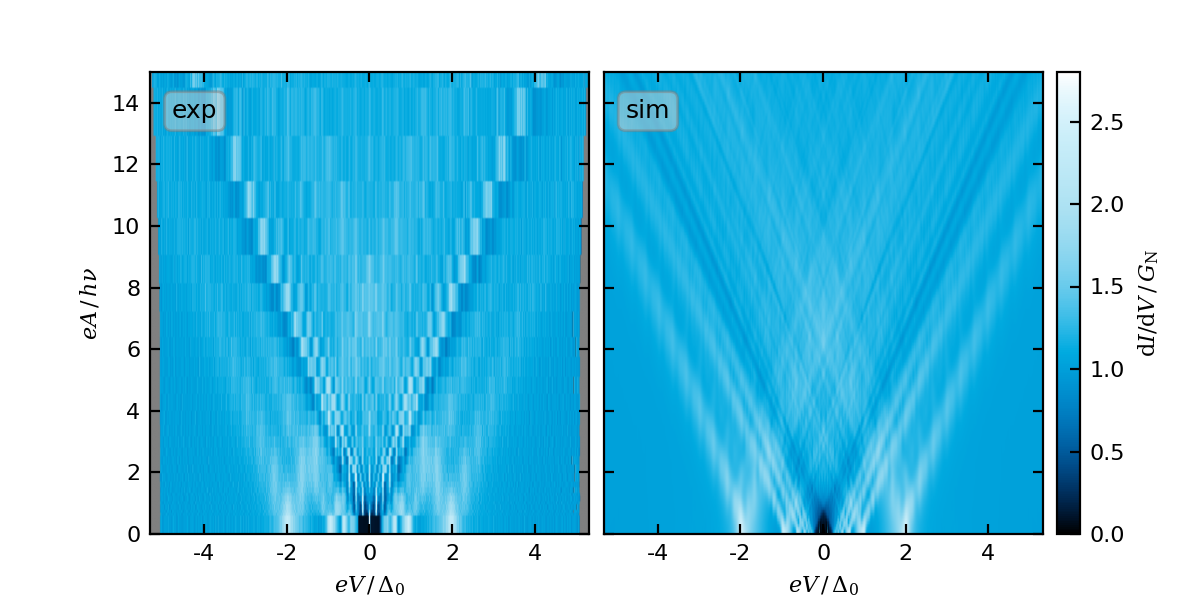

In [27]:
# exp / pamar
V_label = r"$eV\,/\,\Delta_0$"
A_label = r"$eA\,/\,h\nu$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"

index0 = np.argmin(np.abs(V_mV / Delta_meV))
index1 = np.argmin(np.abs(V_mV / Delta_meV - 8))
img_z = np.concatenate((dIdV_exp[:, 1:index0], dIdV_pamar[:, index0:]), axis=1)
img_exp = dIdV_exp / G_N
img_sim = dIdV_pamar / G_N
img_x = V_mV / Delta_meV
img_y = A_hnu

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=1,
    ncols=3,
    width_ratios=(3.9, 3.9, 0.2),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_exp = axs[0]
ax_sim = axs[1]
ax_clb = axs[2]

for ax in [ax_exp, ax_sim, ax_clb]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_exp.imshow(
    img_exp,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

im = ax_sim.imshow(
    img_sim,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
)
ax_sim.yaxis.set_ticklabels([])

ax_exp.set_xlabel(V_label)
ax_sim.set_xlabel(V_label)
ax_exp.set_ylabel(A_label)

ax_exp.set_ylim(0, 15)
ax_sim.set_ylim(0, 15)

ax_exp.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_exp.transAxes)
ax_sim.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_sim.transAxes)

fig.savefig(
    f"exp_sim_{nu_GHz}GHz.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

In [23]:
from pat import get_I_pat_nA

dIdV_sc = np.where(np.abs(V_mV) / Delta_meV < 0.025, dIdV_exp[0, :], 0.0)

dIdV_ccpt = np.abs(
    get_I_pat_nA(
        V_mV=V_mV,
        A_mV=A_mV,
        I_nA=dIdV_sc,
        nu_GHz=nu_GHz,
        n_max=100,
        m=2,
        exp=1,
    )
)
dIdV_icpt = get_I_pat_nA(
    V_mV=V_mV,
    A_mV=A_mV,
    I_nA=dIdV_sc,
    nu_GHz=nu_GHz,
    n_max=100,
    m=2,
    exp=2,
)

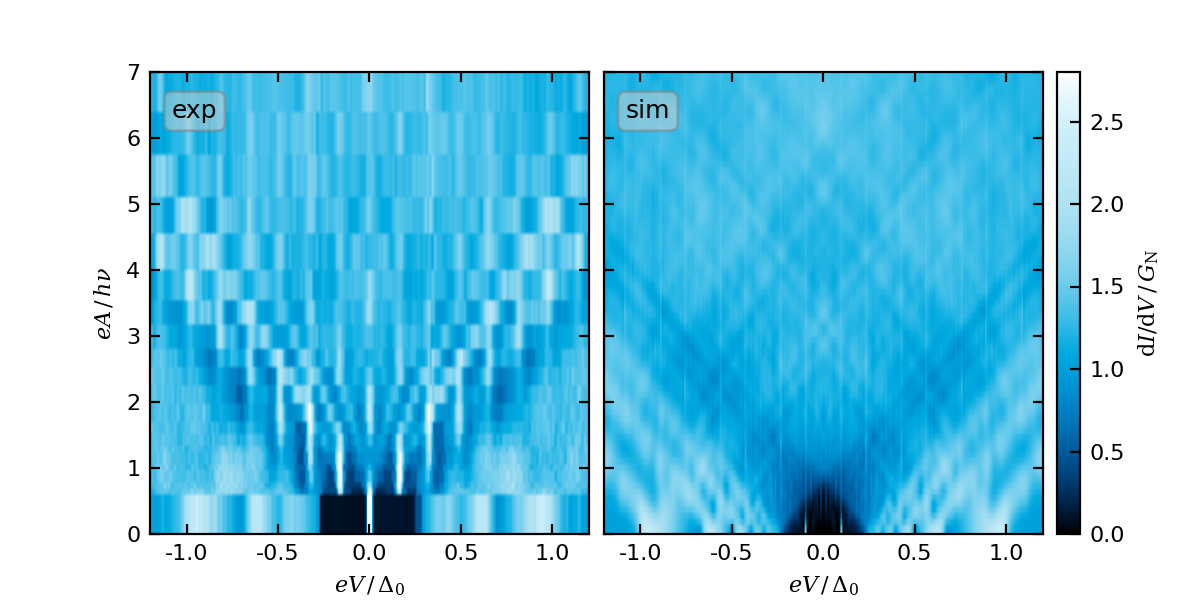

In [24]:
# exp / pamar + no-cpt
V_label = r"$eV\,/\,\Delta_0$"
A_label = r"$eA\,/\,h\nu$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"

index0 = np.argmin(np.abs(V_mV / Delta_meV))
index1 = np.argmin(np.abs(V_mV / Delta_meV - 8))
img_z = np.concatenate((dIdV_exp[:, 1:index0], dIdV_pamar[:, index0:]), axis=1)
img_exp = dIdV_exp / G_N
img_sim = (dIdV_pamar) / G_N
img_x = V_mV / Delta_meV
img_y = A_hnu

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=1,
    ncols=3,
    width_ratios=(3.9, 3.9, 0.2),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_exp = axs[0]
ax_sim = axs[1]
ax_clb = axs[2]

for ax in [ax_exp, ax_sim, ax_clb]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_exp.imshow(
    img_exp,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

im = ax_sim.imshow(
    img_sim,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
)
ax_sim.yaxis.set_ticklabels([])

ax_exp.set_xlabel(V_label)
ax_sim.set_xlabel(V_label)
ax_exp.set_ylabel(A_label)

ax_exp.set_ylim(0, 7)
ax_sim.set_ylim(0, 7)
ax_exp.set_xlim(-1.2, 1.2)
ax_sim.set_xlim(-1.2, 1.2)

ax_exp.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_exp.transAxes)
ax_sim.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_sim.transAxes)

fig.savefig(
    f"exp_no-cpt_{nu_GHz}GHz.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

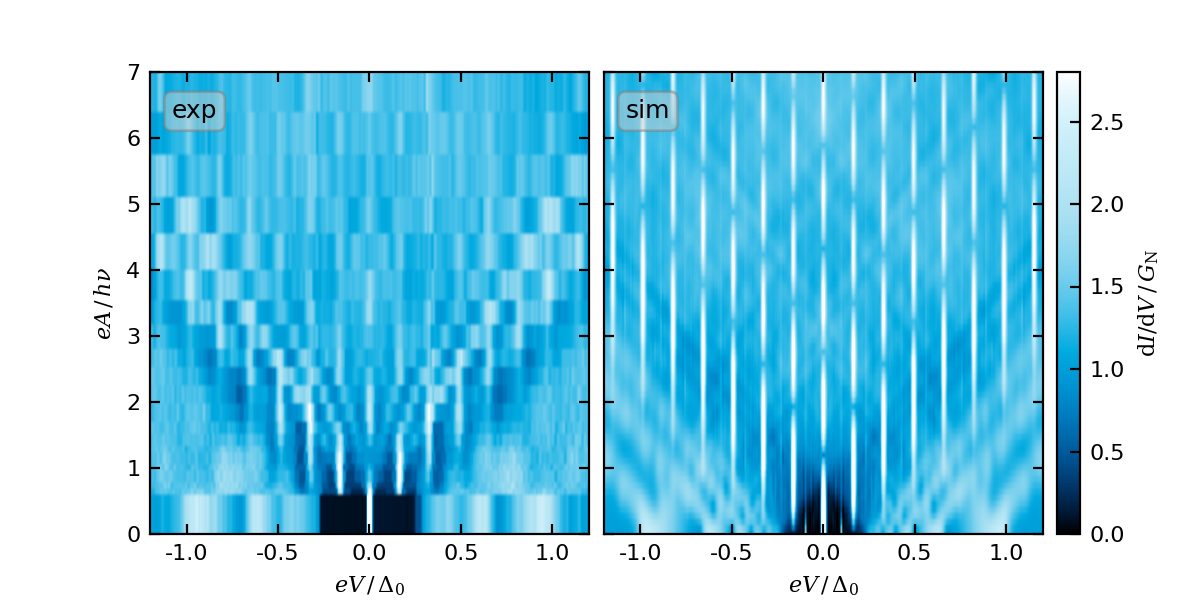

In [25]:
# exp / pamar + ccpt
V_label = r"$eV\,/\,\Delta_0$"
A_label = r"$eA\,/\,h\nu$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"

index0 = np.argmin(np.abs(V_mV / Delta_meV))
index1 = np.argmin(np.abs(V_mV / Delta_meV - 8))
img_z = np.concatenate((dIdV_exp[:, 1:index0], dIdV_pamar[:, index0:]), axis=1)
img_exp = dIdV_exp / G_N
img_sim = (dIdV_pamar + dIdV_ccpt) / G_N
img_x = V_mV / Delta_meV
img_y = A_hnu

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=1,
    ncols=3,
    width_ratios=(3.9, 3.9, 0.2),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_exp = axs[0]
ax_sim = axs[1]
ax_clb = axs[2]

for ax in [ax_exp, ax_sim, ax_clb]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_exp.imshow(
    img_exp,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

im = ax_sim.imshow(
    img_sim,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
)
ax_sim.yaxis.set_ticklabels([])

ax_exp.set_xlabel(V_label)
ax_sim.set_xlabel(V_label)
ax_exp.set_ylabel(A_label)

ax_exp.set_ylim(0, 7)
ax_sim.set_ylim(0, 7)
ax_exp.set_xlim(-1.2, 1.2)
ax_sim.set_xlim(-1.2, 1.2)

ax_exp.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_exp.transAxes)
ax_sim.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_sim.transAxes)

fig.savefig(
    f"exp_ccpt_{nu_GHz}GHz.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)

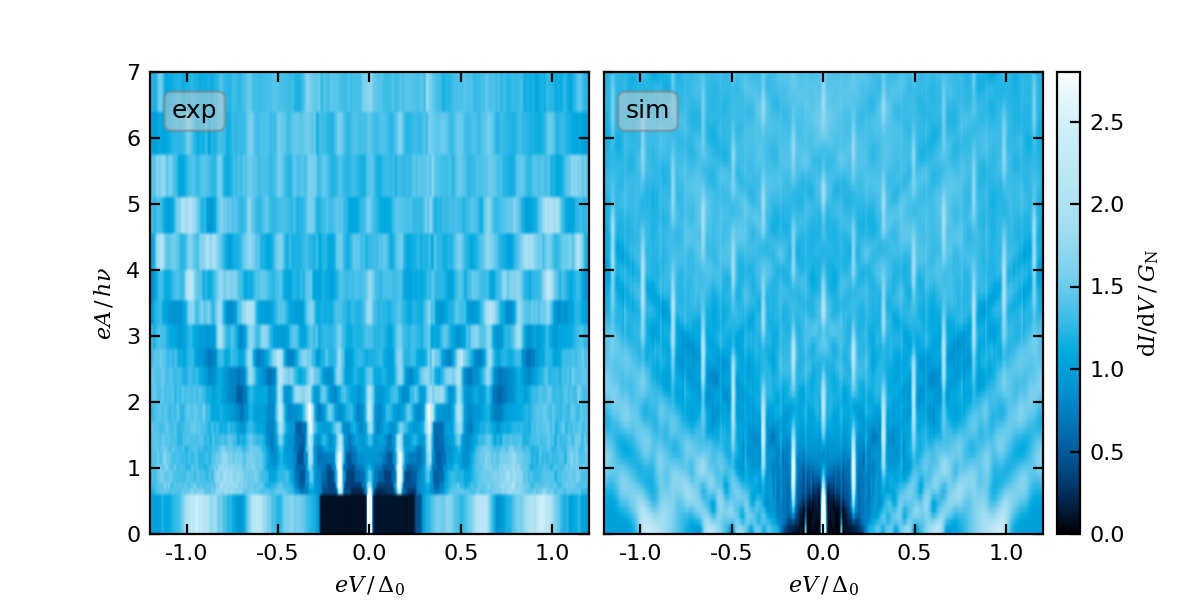

In [26]:
# exp / pamar + icpt
V_label = r"$eV\,/\,\Delta_0$"
A_label = r"$eA\,/\,h\nu$"
G_label = r"$\mathrm{d}I/\mathrm{d}V\,/\,G_\mathrm{N}$"

index0 = np.argmin(np.abs(V_mV / Delta_meV))
index1 = np.argmin(np.abs(V_mV / Delta_meV - 8))
img_z = np.concatenate((dIdV_exp[:, 1:index0], dIdV_pamar[:, index0:]), axis=1)
img_exp = dIdV_exp / G_N
img_sim = (dIdV_pamar + dIdV_icpt) / G_N
img_x = V_mV / Delta_meV
img_y = A_hnu

dx, dy = img_x[-1] - img_x[-2], img_y[-1] - img_y[-2]
ext = (img_x[0] - dx / 2, img_x[-1] + dx / 2, img_y[0] - dy / 2, img_y[-1] + dy / 2)
clim = (
    np.nanmean(img_z) - 2 * np.nanstd(img_z),
    np.nanmean(img_z) + 2 * np.nanstd(img_z),
)
clim = (0, 2.8)

# fig and axs
fig, axs = plt.subplots(
    figsize=(6, 3),
    nrows=1,
    ncols=3,
    width_ratios=(3.9, 3.9, 0.2),
    # sharex = True
)
plt.subplots_adjust(hspace=0.1, wspace=0.05)
ax_exp = axs[0]
ax_sim = axs[1]
ax_clb = axs[2]

for ax in [ax_exp, ax_sim, ax_clb]:
    ax.tick_params(
        direction="in",  # Ticks nach innen
        top=True,  # obere Ticks ein
        bottom=True,  # untere Ticks ein
        left=True,  # linke Ticks ein
        right=True,  # rechte Ticks ein
        which="both",  # sowohl Major- als auch Minor-Ticks
    )


im = ax_exp.imshow(
    img_exp,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

im = ax_sim.imshow(
    img_sim,
    aspect="auto",
    origin="lower",
    clim=clim,
    extent=ext,
    interpolation=None,
    cmap=cmap(bad="grey"),
)

cbar = fig.colorbar(
    im,
    cax=ax_clb,
    label=G_label,
)
ax_sim.yaxis.set_ticklabels([])

ax_exp.set_xlabel(V_label)
ax_sim.set_xlabel(V_label)
ax_exp.set_ylabel(A_label)

ax_exp.set_ylim(0, 7)
ax_sim.set_ylim(0, 7)
ax_exp.set_xlim(-1.2, 1.2)
ax_sim.set_xlim(-1.2, 1.2)


ax_exp.text(0.05, 0.9, "exp", fontsize=9, bbox=bbox, transform=ax_exp.transAxes)
ax_sim.text(0.05, 0.9, "sim", fontsize=9, bbox=bbox, transform=ax_sim.transAxes)

fig.savefig(
    f"exp_icpt_{nu_GHz}GHz.png",
    dpi=600,
    transparent=True,
    facecolor="none",
    edgecolor="none",
)